In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import applications, models

from utils import create_model, train_gen_overlay2, load_images, load_backgrounds, show_batch

In [2]:
images_path = "countries/data/flags/PNG-128/"

trained_model = applications.InceptionV3(weights="imagenet")
module = applications.inception_v3
width, height = 299, 299

df = pd.read_sql_table("Countries", "sqlite:///countries/data/sqlite/countries.db")

images, masks = load_images(df, images_path,  module)

n_classes = images.shape[0]
y = np.identity(n_classes)

assert df.notnull().all().all()

for col in ['code3l', 'code2l', 'name', 'name_official', 'flag_32',
       'flag_128']:
    assert (df[col].value_counts() == 1).all()
    
    
backgrounds = load_backgrounds("val2017/*.jpg", module, width, height, lim=1000)

In [3]:
seq2 = create_model(n_classes, train_batch_norm=False)

In [4]:
batch_size = 128
train_gen = train_gen_overlay2(batch_size, backgrounds, images, masks, y)
#test_gen = train_gen_overlay2(batch_size, test_backgrounds, images, masks)

seq2.load_weights("inception3_run_[]_cls_250_lr_0.001_bs_128_ts_8_tp_11047162_950.hdf5")


In [7]:
batch, y_batch = next(train_gen)

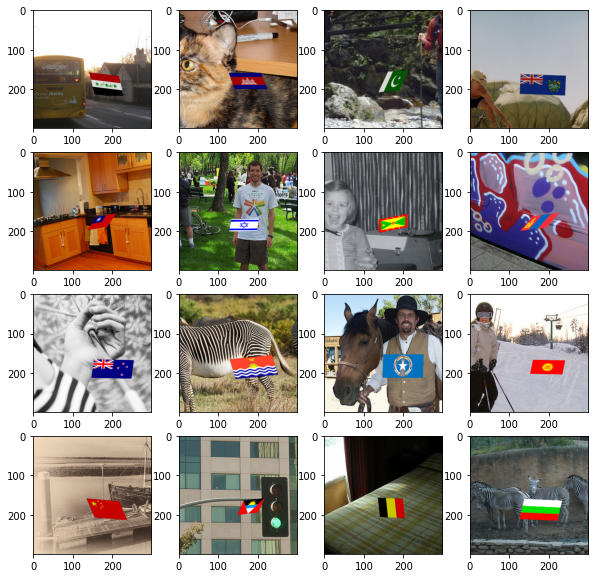

In [8]:
show_batch(batch)

In [15]:
def eval_on_batch(batch, y_batch):
    
    preds_one = seq2(batch, training=False).numpy()
    pred_one = preds_one.argmax(axis=1)
    y_one = y_batch.argmax(axis=1)
    res_batch = pd.DataFrame({"pred": pred_one, "y": y_one})
    return res_batch, pd.DataFrame(preds_one)

def eval_on_batches(train_gen, n_batches):
    probs = []
    res = []
    images_test = []

    for j in range(n_batches):
        print(j)
        batch, y_batch = next(train_gen)
        res_batch, preds_one = eval_on_batch(batch, y_batch)
        res.append(res_batch)
        probs.append(preds_one)
        images_test.append(batch)

    res = pd.concat(res, ignore_index=True)
    probs = pd.concat(probs, ignore_index=True)

    res["wrong"] = res["pred"] != res["y"]
    res["correct"] = res["pred"] == res["y"]
    loss = - np.log(probs).values[np.arange(probs.shape[0]), res["y"].values]
    res["loss"] = loss
    return res

In [16]:
res_batch, pred_one = eval_on_batch(batch, y_batch)

In [27]:
res = eval_on_batches(train_gen, 10)

0
1
2
3
4
5
6
7
8
9


/Users/grisha.oryol/Documents/projects/opencv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


In [28]:
res["correct"].mean()

0.87734375

In [29]:
crosstab_abs = pd.crosstab(res["pred"], res["y"])
crosstab = crosstab_abs.div(crosstab_abs.sum())

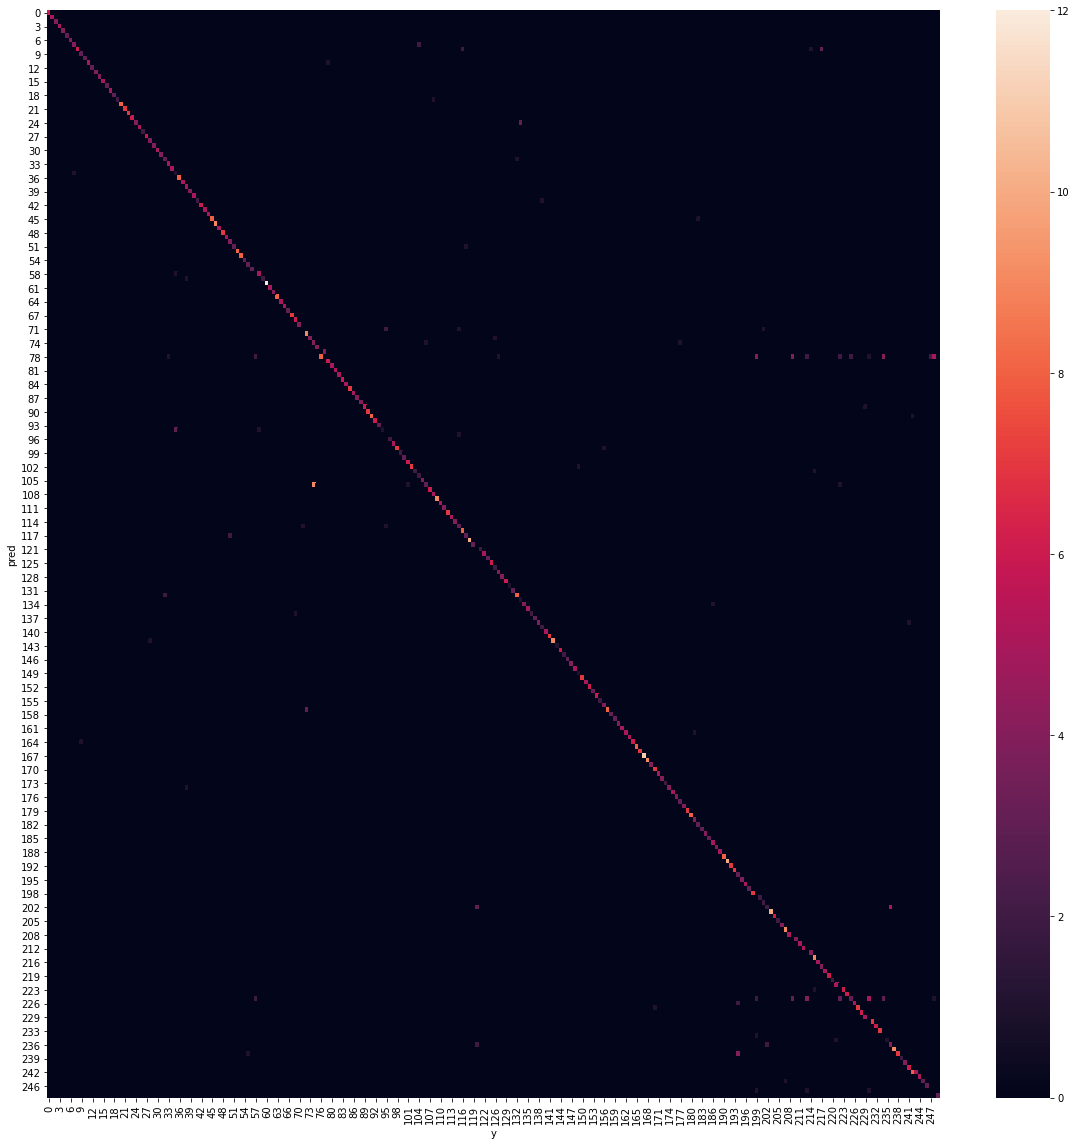

In [30]:
plt.figure(figsize=(20, 20))
sns.heatmap(crosstab_abs)

In [48]:
res[res["wrong"]].groupby(["pred", "y"]).count()["wrong"].sort_values()

pred  y  
102   149    1
91    242    1
94    58     1
95    115    1
98    156    1
            ..
78    248    5
202   236    5
242   243    5
78    76     8
106   74     9
Name: wrong, Length: 80, dtype: int64

In [38]:
images.shape

(250, 64, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


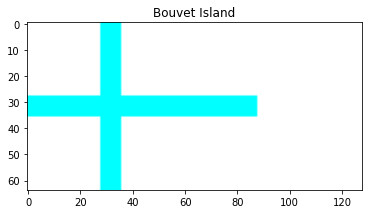

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


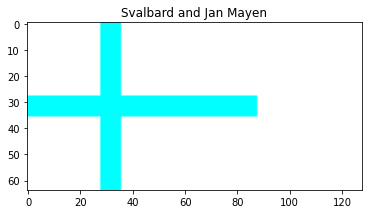

In [51]:
idx1 = 202
idx2 = 236
plt.imshow((images[idx1] + 1) * 0.5 * 256)
plt.title(df["name"][idx1])
plt.show()
plt.imshow((images[idx2] + 1) * 0.5 * 256)
plt.title(df["name"][idx2])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


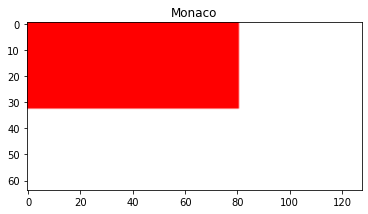

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


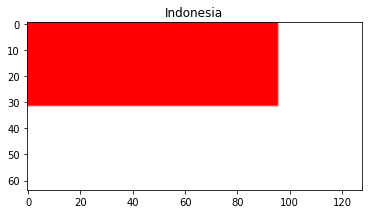

In [49]:
idx1 = 106
idx2 = 74
plt.imshow((images[idx1] + 1) * 0.5 * 256)
plt.title(df["name"][idx1])
plt.show()
plt.imshow((images[idx2] + 1) * 0.5 * 256)
plt.title(df["name"][idx2])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


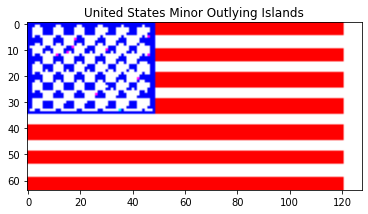

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


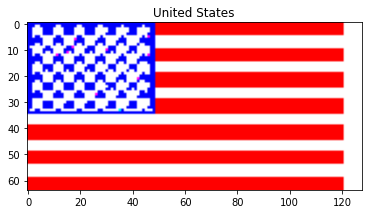

In [50]:
idx1 = 242
idx2 = 243
plt.imshow((images[idx1] + 1) * 0.5 * 256)
plt.title(df["name"][idx1])
plt.show()
plt.imshow((images[idx2] + 1) * 0.5 * 256)
plt.title(df["name"][idx2])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


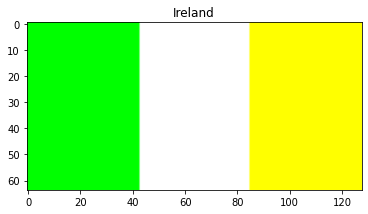

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


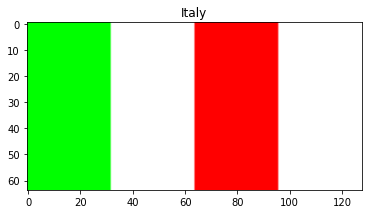

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


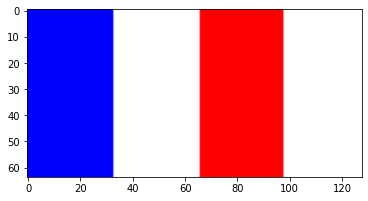

In [45]:
plt.imshow((images[76] + 1) * 0.5 * 256)
plt.title(df["name"][76])
plt.show()
plt.imshow((images[78] + 1) * 0.5 * 256)
plt.title(df["name"][78])
plt.show()
plt.imshow((images[209] + 1) * 0.5 * 256)
plt.show()

In [74]:
import shap

In [78]:
explainer = shap.DeepExplainer(seq2, batch[:2])

In [ ]:
shap_vals = explainer.shap_values(batch[:1])